In [1]:
!pip install opencv-python
!pip install seaborn
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 28.7 MB/s eta 0:00:0000:0100:01
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 4.9 MB/s eta 0:00:00a 0:00:01
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 4.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 41.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 KB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 41.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 42.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 KB 6.2 MB/s eta

In [2]:
import os  # Importing the OS module to interact with the operating system
import time  # Importing the Time module to handle time-related tasks
import shutil  # Importing the Shutil module for high-level file operations
import pathlib  # Importing the Pathlib module for object-oriented filesystem paths
import itertools  # Importing the Itertools module for creating iterators
from PIL import Image  # Importing the Image module from PIL (Pillow) for image processing

import cv2  # Importing the OpenCV library for computer vision tasks
import numpy as np  # Importing the Numpy library for numerical operations

import pandas as pd  # Importing the Pandas library for data manipulation
import seaborn as sns  # Importing the Seaborn library for statistical data visualization
sns.set_style('darkgrid')  # Setting the style for Seaborn plots
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting
from sklearn.model_selection import train_test_split  # Importing train_test_split for splitting data into training and testing sets
from sklearn.metrics import confusion_matrix, classification_report  # Importing metrics for evaluating model performance

import torch  # Importing the PyTorch library for deep learning
import torch.nn as nn  # Importing the neural network module from PyTorch
import torch.optim as optim  # Importing the optimization module from PyTorch
from torch.utils.data import DataLoader, Dataset  # Importing DataLoader and Dataset classes for data handling
from torchvision import transforms, models  # Importing transforms and models from torchvision
from torchvision.datasets import ImageFolder  # Importing ImageFolder for loading datasets from directories

import warnings  # Importing the warnings module to manage warnings
warnings.filterwarnings("ignore")  # Ignoring all warnings

print('modules loaded')  # Printing a confirmation that modules are loaded

modules loaded


In [3]:
model_dir = os.environ['FINN_ROOT'] + "/notebooks/FINN_Brevitas"
data_path = model_dir + "/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"

images = []  # Initializing an empty list to store image paths
labels = []  # Initializing an empty list to store labels

for subfolder in os.listdir(data_path):  # Iterating through each subfolder in the dataset path
    subfolder_path = os.path.join(data_path, subfolder)  # Constructing the path to the subfolder
    if not os.path.isdir(subfolder_path):  # Checking if the path is a directory
        continue  # Skipping if it's not a directory

    for image_filename in os.listdir(subfolder_path):  # Iterating through each file in the subfolder
        image_path = os.path.join(subfolder_path, image_filename)  # Constructing the path to the image
        images.append(image_path)  # Appending the image path to the images list
        labels.append(subfolder)  # Appending the subfolder name (label) to the labels list

data = pd.DataFrame({'image': images, 'label': labels})  # Creating a DataFrame from the images and labels lists
data.head()  # Displaying the first few rows of the DataFrame
data.shape  # Displaying the shape of the DataFrame
strat = data['label']  # Extracting the labels column for stratification
train_df, dummy_df = train_test_split(data, train_size=0.80, shuffle=True, random_state=123, stratify=strat)  # Splitting the data into training and a temporary set

strat = dummy_df['label']  # Extracting labels from the temporary set for stratification
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)  # Splitting the temporary set into validation and test sets
print("Training set shape:", train_df.shape)  # Printing the shape of the training set
print("Validation set shape:", valid_df.shape)  # Printing the shape of the validation set
print("Test set shape:", test_df.shape)  # Printing the shape of the test set
batch_size = 16  # Setting the batch size for data loaders
img_size = (224, 224)  # Setting the image size
channels = 3  # Setting the number of color channels
img_shape = (img_size[0], img_size[1], channels)  # Defining the shape of the image

# Define custom Dataset class
class CustomDataset(Dataset):  # Defining a custom dataset class
    def __init__(self, dataframe, transform=None, class_indices=None):  # Initializing the dataset
        self.dataframe = dataframe  # Storing the dataframe
        self.transform = transform  # Storing the transformations
        self.class_indices = class_indices  # Storing class indices

    def __len__(self):  # Defining the length method
        return len(self.dataframe)  # Returning the length of the dataframe

    def __getitem__(self, idx):  # Defining the get item method
        img_path = self.dataframe.iloc[idx]['image']  # Getting the image path
        image = Image.open(img_path).convert('RGB')  # Opening the image and converting to RGB
        label = self.class_indices[self.dataframe.iloc[idx]['label']]  # Getting the label

        if self.transform:  # Applying transformations if available
            image = self.transform(image)  # Applying the transformations

        return image, label  # Returning the image and label

# Define transformations
transform = transforms.Compose([  # Defining a set of transformations
    transforms.Resize((224, 224)),  # Resizing the image to 224x224
    transforms.ToTensor(),  # Converting the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizing the image
])


class_indices = {label: idx for idx, label in enumerate(train_df['label'].unique())}  # Creating a dictionary for class indices

train_dataset = CustomDataset(train_df, transform=transform, class_indices=class_indices)  # Creating the training dataset
valid_dataset = CustomDataset(valid_df, transform=transform, class_indices=class_indices)  # Creating the validation dataset
test_dataset = CustomDataset(test_df, transform=transform, class_indices=class_indices)  # Creating the test dataset

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Creating the training data loader
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)  # Creating the validation data loader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # Creating the test data loader

print(class_indices)  # Printing the class indices

Training set shape: (9956, 2)
Validation set shape: (1245, 2)
Test set shape: (1245, 2)
{'Normal': 0, 'Tumor': 1, 'Stone': 2, 'Cyst': 3}


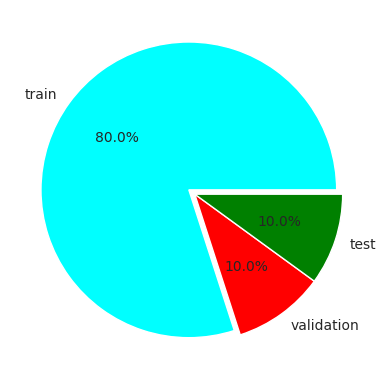

<Figure size 640x480 with 0 Axes>

In [4]:
# Plot dataset distribution
plt.pie([len(train_loader), len(valid_loader), len(test_loader)],  # Creating a pie chart
        labels=['train', 'validation', 'test'], autopct='%.1f%%', colors=['aqua', 'red', 'green'], explode=(0.05, 0, 0))  # Setting labels, colors, and explode
plt.show()  # Displaying the pie chart
plt.savefig('dataset_pie.png')  # Saving the pie chart

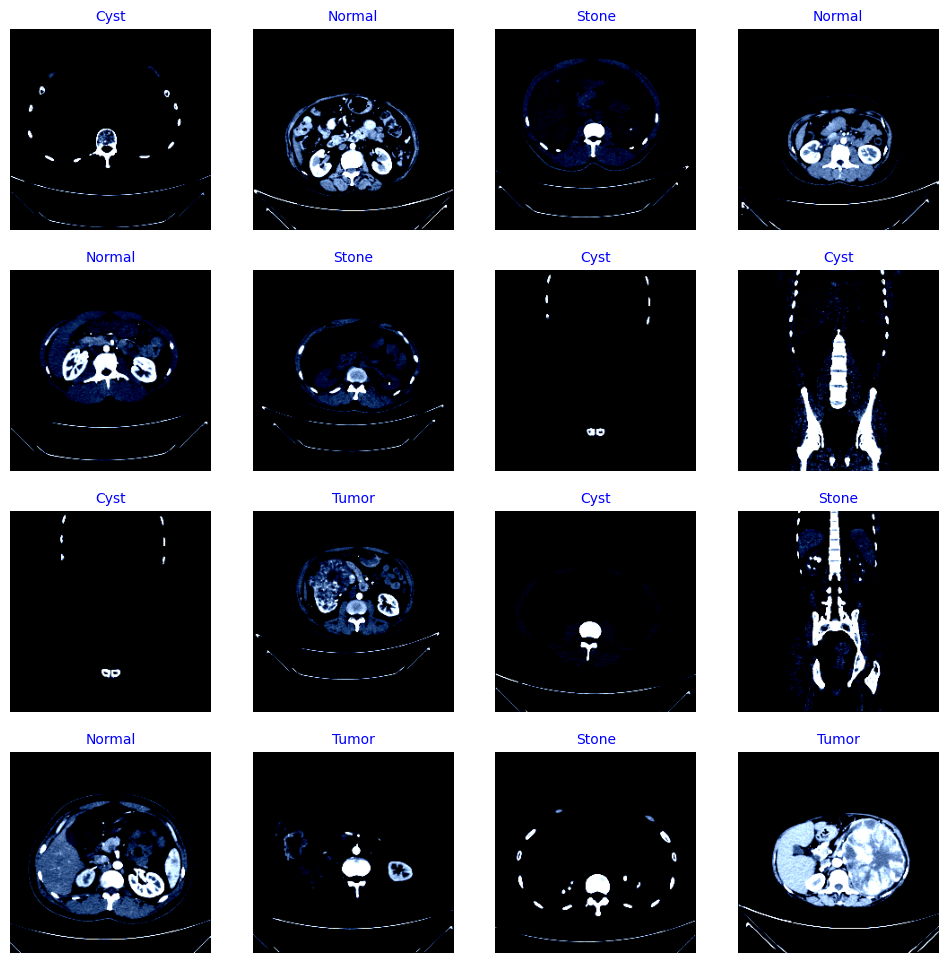

In [5]:
g_dict = class_indices  # Storing class indices
classes = list(g_dict.keys())  # Getting class names
images, labels = next(iter(train_loader))  # Getting a batch of images and labels

plt.figure(figsize=(12, 12))  # Setting the figure size

for i in range(16):  # Iterating through the first 16 images
    plt.subplot(4, 4, i + 1)  # Creating a subplot
    image = images[i].permute(1, 2, 0).numpy()  # Permuting and converting the image to numpy
    image = np.clip(image, 0, 1)  # Clipping the image values to [0, 1]
    plt.imshow(image)  # Displaying the image
    index = labels[i].item()  # Getting the label index
    class_name = classes[index]  # Getting the class name
    plt.title(class_name, color='blue', fontsize=10)  # Setting the title of the subplot
    plt.axis('off')  # Hiding the axis
plt.show()  # Displaying the figure

# mobilenet v2 BReVitas

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import brevitas.nn as qnn
from brevitas.quant import Int8WeightPerTensorFixedPoint as WeightQuant
from brevitas.quant import Int8ActPerTensorFixedPoint as ActQuant

In [7]:
class DepthWise_Conv(nn.Module):
    def __init__(self, in_fts, stride=(1,1)) -> None:
        super().__init__()
        self.conv = nn.Sequential(
            qnn.QuantConv2d(in_fts, in_fts, kernel_size=(3,3), stride=stride, padding=(1,1), groups=in_fts, 
                            bias=False, weight_quant=WeightQuant),
            nn.BatchNorm2d(in_fts),
            nn.ReLU6(inplace=True)
        )

    def forward(self, input_image):
        x = self.conv(input_image)
        return x

In [8]:
class Pointwise_Conv(nn.Module):
    def __init__(self, in_fts, out_fts) -> None:
        super().__init__()
        self.conv = nn.Sequential(
            qnn.QuantConv2d(in_fts, out_fts, kernel_size=(1,1), bias=False, weight_quant=WeightQuant),
            nn.BatchNorm2d(out_fts)
        )
    def forward(self, input_image):
        x = self.conv(input_image)
        return x

In [9]:
class NetForStrideOne(nn.Module):
    def __init__(self, in_fts, out_fts, expansion) -> None:
        super().__init__()
        self.conv1 = nn.Sequential(
            qnn.QuantConv2d(in_fts, expansion*in_fts, kernel_size=(1,1), bias=False, weight_quant=WeightQuant),
            nn.BatchNorm2d(expansion*in_fts),
            nn.ReLU6(inplace=True)
        )
        self.dw = DepthWise_Conv(expansion*in_fts)
        self.pw = Pointwise_Conv(expansion*in_fts, out_fts)

        self.in_fts = in_fts
        self.out_fts = out_fts
        self.expansion = expansion

    def forward(self, input_image):
        if self.expansion == 1:
            x = self.dw(input_image)
            x = self.pw(x)
        else:
            x = self.conv1(input_image)
            x = self.dw(x)
            x = self.pw(x)

        if self.in_fts == self.out_fts:
            x = input_image + x          

        return x

In [10]:
class NetForStrideTwo(nn.Module):
    def __init__(self, in_fts, out_fts, expansion) -> None:
        super().__init__()
        self.conv1 = nn.Sequential(
            qnn.QuantConv2d(in_fts, expansion*in_fts, kernel_size=(1,1), bias=False, weight_quant=WeightQuant),
            nn.BatchNorm2d(expansion*in_fts),
            nn.ReLU6(inplace=True)
        )
        self.dw = DepthWise_Conv(expansion*in_fts, stride=(2,2))
        self.pw = Pointwise_Conv(expansion*in_fts, out_fts)

        self.expansion = expansion

    def forward(self, input_image):
        if self.expansion == 1:
            x = self.dw(input_image)
            x = self.pw(x)
        else:
            x = self.conv1(input_image)
            x = self.dw(x)
            x = self.pw(x)      

        return x

In [11]:
class MyMobileNet_v2(nn.Module):
    def __init__(self, bottleneckLayerDetails, in_fts=3, numClasses=4, width_multiplier=1):  # Adjust numClasses to 4
        super().__init__()
        self.bottleneckLayerDetails = bottleneckLayerDetails
        self.width_multiplier = width_multiplier

        self.conv1 = nn.Sequential(
            qnn.QuantConv2d(in_fts, round(width_multiplier*32), kernel_size=(3,3), stride=(2,2), padding=(1,1), bias=False, 
                            weight_quant=WeightQuant),
            nn.BatchNorm2d(round(width_multiplier*32)),
            nn.ReLU6(inplace=True)
        )
        self.in_fts = round(width_multiplier*32)
        
        self.layerConstructed = self.constructLayer()

        self.feature = nn.Sequential(
            qnn.QuantConv2d(self.in_fts, round(width_multiplier*1280), kernel_size=(1,1), bias=False, weight_quant=WeightQuant),
            nn.BatchNorm2d(round(width_multiplier*1280)),
            nn.ReLU6(inplace=True)
        )

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))

        self.outputLayer = nn.Sequential(
            nn.Dropout2d(),
            qnn.QuantConv2d(round(width_multiplier*1280), numClasses, kernel_size=(1,1), weight_quant=WeightQuant),
            nn.Flatten()  # Add Flatten layer to output the correct shape for classification
        )

    def forward(self, input_image):
        x = self.conv1(input_image)
        x = self.layerConstructed(x)
        x = self.feature(x)
        x = self.avgpool(x)
        x = self.outputLayer(x)
        return x

    def constructLayer(self):
        itemIndex = 0
        block = OrderedDict()
        for lItem in self.bottleneckLayerDetails:
            t, out_fts, n, stride = lItem
            out_fts = round(self.width_multiplier*out_fts)
            if stride == 1:
                for nItem in range(n):
                    block[str(itemIndex)+"_"+str(nItem)] = NetForStrideOne(self.in_fts, out_fts, t)
                    self.in_fts = out_fts
            elif stride == 2:
                block[str(itemIndex)+"_"+str(0)] = NetForStrideTwo(self.in_fts, out_fts, t)
                self.in_fts = out_fts
                for nItem in range(1,n):
                    block[str(itemIndex)+"_"+str(nItem)] = NetForStrideOne(self.in_fts, out_fts, t)
            itemIndex += 1

        return nn.Sequential(block)

In [12]:
from collections import OrderedDict

In [13]:
# Instantiate the model
bottleneckLayerDetails = [
    (1,16,1,1),
    (6,24,2,2),
    (6,32,3,2),
    (6,64,4,2),
    (6,96,3,1),
    (6,160,3,2),
    (6,320,1,1)
]

model = MyMobileNet_v2(bottleneckLayerDetails, numClasses=len(class_indices), width_multiplier=1)

In [14]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Classification task
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
# Training and Validation Loop
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            
            running_loss += loss.item() * images.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')
        
        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        correct = 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels.data)
        
        val_loss = val_loss / len(valid_loader.dataset)
        val_acc = correct.double() / len(valid_loader.dataset)
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')
    
    print('Training complete')

# Model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device: ", device)
model.to(device)

# Train the model
train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=2)

Epoch 1/2, Training Loss: 0.4146
Validation Loss: 0.2384, Validation Accuracy: 0.9189
Epoch 2/2, Training Loss: 0.1220
Validation Loss: 0.0392, Validation Accuracy: 0.9863
Training complete


In [16]:
# Test the model
model.eval()  # Set model to evaluation mode
test_loss = 0.0
correct = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels.data)

test_loss = test_loss / len(test_loader.dataset)
test_acc = correct.double() / len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

Test Loss: 0.0401, Test Accuracy: 0.9855


In [17]:
# Evaluate model performance
import time

def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    total_time = 0.0  # Total inference time for all batches
    total_images = 0  # Total number of images processed
    batch_times = []  # List to store latency (time per batch)

    with torch.no_grad():  # Disable gradient computation for inference
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Start timing for the current batch
            start_time = time.time()

            # Forward pass (inference)
            outputs = model(images)

            # End timing for the current batch
            end_time = time.time()

            # Calculate latency (time taken for the current batch)
            batch_latency = end_time - start_time
            batch_times.append(batch_latency)

            # Accumulate total time and total number of images processed
            total_time += batch_latency
            total_images += images.size(0)

    # Calculate average latency (mean of batch times)
    avg_latency = sum(batch_times) / len(batch_times)

    # Total inference time (total time taken for all batches)
    total_inference_time = total_time

    # Throughput (number of images processed per second)
    throughput = total_images / total_inference_time

    print(f"Average Latency per Batch: {avg_latency:.6f} seconds")
    print(f"Total Inference Time: {total_inference_time:.6f} seconds")
    print(f"Throughput: {throughput:.2f} images/second")

# Assuming test_loader is prepared
evaluate_model(model, test_loader, device)

Average Latency per Batch: 0.036892 seconds
Total Inference Time: 2.877613 seconds
Throughput: 432.65 images/second


# Export to ONNX for FINN

In [19]:
import torch
import torch.onnx

model.to("cpu")

# Define input shape for the model (e.g., batch size 1, 3 channels, 224x224 image)
input_shape = (1, 3, 224, 224)  # Adjust as per your model's input dimensions
dummy_input = torch.randn(*input_shape)

# Path to save the exported ONNX model
export_onnx_path = "quantized_mobilenet_v2.onnx"

# Export the quantized model to ONNX
torch.onnx.export(
    model,                # The model to export
    dummy_input,          # Dummy input for model tracing
    export_onnx_path,     # Path where the model will be saved
    export_params=True,   # Export trained parameters
    opset_version=12,     # ONNX opset version to use
    do_constant_folding=True,  # Whether to fold constants
    input_names=['input'],   # Name of the input tensor
    output_names=['output'], # Name of the output tensor
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}  # For dynamic batch size
)

In [20]:
from qonnx.core.modelwrapper import ModelWrapper
from qonnx.core.datatype import DataType

# Load the ONNX model
model_file = "quantized_mobilenet_v2.onnx"
model = ModelWrapper(model_file)

# Set tensor data type if needed (e.g., INT8 for quantized models)
model.set_tensor_datatype(model.graph.input[0].name, DataType["UINT8"])

# Save the updated model
model.save(model_file)

In [21]:
from finn.util.visualization import showInNetron

# Visualize the ONNX model
showInNetron("quantized_mobilenet_v2.onnx")

OSError: [Errno 98] Address already in use

# Build the Quantized CNN with FINN

In [22]:
import finn.builder.build_dataflow as build
import finn.builder.build_dataflow_config as build_cfg

# Specify the path to your quantized MobileNetV2 ONNX model
model_file = "quantized_mobilenet_v2.onnx"
rtlsim_output_dir = "mobilenetv2_rtlsim"  # Adjust the output directory name

# Configure the build process
cfg = build.DataflowBuildConfig(
    # Target performance and clock frequency
    target_fps=300000000,
    synth_clk_period_ns=10.0,  # Adjusted clock period for PYNQ-Z1
    # Target FPGA part number for PYNQ-Z1
    fpga_part="xc7z020clg400-1",
    # Directory where outputs will be written
    output_dir=rtlsim_output_dir,
    # Enable full unfolding
    mvau_wwidth_max=1000000,
    # Which output products to generate
    generate_outputs=[
        build_cfg.DataflowOutputType.STITCHED_IP,
        build_cfg.DataflowOutputType.RTLSIM_PERFORMANCE,
    ]
)

In [23]:
# Initiate the build process with the configured settings
build.build_dataflow_cfg(model_file, cfg)

Building dataflow accelerator from quantized_mobilenet_v2.onnx
Intermediate outputs will be generated in /tmp/finn_dev_emanuel
Final outputs will be generated in mobilenetv2_rtlsim
Build log is at mobilenetv2_rtlsim/build_dataflow.log
Running step: step_qonnx_to_finn [1/19]
Running step: step_tidy_up [2/19]
Running step: step_streamline [3/19]


Traceback (most recent call last):
  File "/home/emanuel/workspace/finn/src/finn/builder/build_dataflow.py", line 158, in build_dataflow_cfg
    model = transform_step(model, cfg)
  File "/home/emanuel/workspace/finn/src/finn/builder/build_dataflow_steps.py", line 314, in step_streamline
    model = model.transform(Streamline())
  File "/home/emanuel/workspace/finn/deps/qonnx/src/qonnx/core/modelwrapper.py", line 140, in transform
    (transformed_model, model_was_changed) = transformation.apply(transformed_model)
  File "/home/emanuel/workspace/finn/src/finn/transformation/streamline/__init__.py", line 98, in apply
    model = model.transform(trn)
  File "/home/emanuel/workspace/finn/deps/qonnx/src/qonnx/core/modelwrapper.py", line 140, in transform
    (transformed_model, model_was_changed) = transformation.apply(transformed_model)
  File "/home/emanuel/workspace/finn/src/finn/transformation/streamline/absorb.py", line 192, in apply
    assert A is not None, "Initializer for mul weig

> /home/emanuel/workspace/finn/src/finn/transformation/streamline/absorb.py(192)apply()
    190                 mul_weight_name = n.input[1]
    191                 A = model.get_initializer(mul_weight_name)
--> 192                 assert A is not None, "Initializer for mul weights is not set."
    193                 is_scalar = np.prod(A.shape) == 1
    194                 actual_ndims = len(tuple(filter(lambda x: x > 1, A.shape)))

--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user
Build failed


-1

In [ ]:
# Examine the generated outputs

In [ ]:
! ls {rtlsim_output_dir}/stitched_ip

In [ ]:
! cat {rtlsim_output_dir}/report/rtlsim_performance.json

In [ ]:
# verify generated RTL model's accuracy

In [ ]:
from finn.core.onnx_exec import execute_onnx
from finn.util.basic import gen_finn_dt_tensor

rtlsim_model = ModelWrapper (rtlsim_output_dir + "/intermediate_models/11_step_create_stitched_ip.onnx")
rtlsim_model.set_metadata_prop("exec_mode","rtlsim")

In [ ]:
def test_rtlsim_model_on_dataset(model, test_loader):
    y_true =[]
    y_pred =[]

    for data in test_loader:
        inputs, target = data
        batch_size = inputs.shape[0]
        model.set_tensor_shape("global_in", (batch_size, 600))
        model.set_tensor_shape("global_out", (batch_size, 1))
        output = execute_onnx(model, {"global_in": inputs.float().numpy()})["global_out"]
        y_pred.extend(list(output.flatten()))
        y_pred.extend(list(target.detach().numpy().flatten()))
    return accuracy_score(y_true, y_pred)

In [ ]:
test_rtlsim_model_on_dataset(rtlsim_model, test_quantized_loader)